# Econometrics 2

## PC-Lab Session 4: Machine Learning for Prediction

**Authors:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)


We want to buy an used car at the online auction platform *MyLemons*. However, we are worried that many used cars on this platform are overpriced. Therefore, we make some market research before we buy an used car. For this purpose, we web-scraped the used car offers from the *MyLemons* platform. We restrict our sample to BMW 320 series, Opel Astra, Mercedes C-class, VW Golf, and VW Passat. We select only used cars with a mileage between 10,000-200,000 km and an age between 1-20 years. 

We obtain the following variables:


|Variable name| Description|
|:----|:----|
|**Outcome variables** ||
|*first_price*| First asking price in 1,000 CHF |
|*final_price*| Transaction price in 1,000 CHF|
|*overprice*| Dummy indicating *first_price > final_price* |
|**Baseline covariates**| |
|*bmw_320, opel_astra, mercedes_c, vw_golf, vw_passat*| Dummies for the car make and model|
|*mileage*| Mileage of the used car (in 1,000 km)|
|*age_car_years*| Age of the used car (in years)|
|*diesel*| Dummy for diesel engines |
|*private_seller*| Dummy for private seller (as opposed to professional used car sellers) |
|*other_car_owner*| Number of previous caar owners |
|*guarantee*| Dummy indicating that the seller offers a guarantee for the used car|
|*maintenance_cert*| Dummy indicating that the seller has a complete maintenace certificate for the used car|
|*inspection*| Categorial variable for the duration until next general inspection (3 categories: new, 1-2 years, < 1 year) |
|*pm_green*| Dummy indicating that the used car has low particular matter emissions|
|*co2_em*| CO2 emssion (in g/km)|
|*euro_norm*| EURO emission norm under which the car is registered |


We store the prepared data in the file *used_cars.csv*.  


## Load Packages

In [19]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('fBasics', 'corrplot', 'psych', 'rpart',
          'rpart.plot', 'treeClust', 'rlang', 'readr', 'devtools',
          'tidyverse', 'reshape2', 'caret', 'plotmo',
          'RandomFieldsUtils', 'rms')


# Load packages
for(pkg in pkgs){
    library(pkg, character.only = TRUE)
}

print('All packages successfully installed and loaded.')

[1] "All packages successfully installed and loaded."


## Load Data Frame

Now we load the data frame and define different covariate categories. We distinguish between binary and continuous/discrete/categorial covariates. Furthermore, we select a subsample of 10,000 used cars in order to decrease the computation time while you are testing your code. We can use the entire sample of 104,719 used cars after we are finised with programming.

In [20]:
########################  Load Data Frame  ########################

set.seed(100239) # set starting value for random number generator

# Load data frame
data_raw <- read.csv("Data/used_cars.csv",header=TRUE, sep=",")

# Outcome Variables
outcomes <- c("first_price", "final_price", "overprice")

# Covariates/Features
baseline_covariates_bin <- c("bmw_320", "opel_astra", "mercedes_c", "vw_golf", "vw_passat", 
                              "diesel", "private_seller", "guarantee", "maintenance_cert",  "pm_green") # binary
baseline_covariates_cont <- c("mileage", "age_car_years", "other_car_owner", "inspection",
                              "co2_em", "euro_norm") # continuous/ordered discrete
baseline_covariates <- c(baseline_covariates_cont,baseline_covariates_bin)
all_variables <- c(outcomes, baseline_covariates)

# Selection of Subsample size, max. 104,719 observations
# Select smaller subsample to decrease computation time
n_obs <- 10000
df <- data_raw %>%
  dplyr::sample_n(n_obs) %>%
  dplyr::select(all_variables)

print('Data frame successfully loaded and sample selected.')

[1] "Data frame successfully loaded and sample selected."


## Descriptive Statistics

### Means and Standard Deviations

In [21]:
########################  Table with Descriptive Statistics  ########################

desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
  select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=1))

                  Mean Stdev Minimum Maximum  nobs
first_price       15.4   7.2     1.2    84.4 10000
final_price       15.3   7.2     1.0    84.4 10000
overprice          0.3   0.5     0.0     1.0 10000
mileage          100.6  50.6    10.0   200.0 10000
age_car_years      4.6   2.6     1.0    19.8 10000
other_car_owner    1.1   0.7     0.0    11.0 10000
inspection         0.9   0.7     0.0     2.0 10000
co2_em           138.5  25.1     1.0   250.0 10000
euro_norm          4.8   0.5     1.0     6.0 10000
bmw_320            0.2   0.4     0.0     1.0 10000
opel_astra         0.1   0.3     0.0     1.0 10000
mercedes_c         0.1   0.4     0.0     1.0 10000
vw_golf            0.2   0.4     0.0     1.0 10000
vw_passat          0.3   0.5     0.0     1.0 10000
diesel             0.8   0.4     0.0     1.0 10000
private_seller     0.1   0.3     0.0     1.0 10000
guarantee          0.1   0.3     0.0     1.0 10000
maintenance_cert   0.7   0.4     0.0     1.0 10000
pm_green           0.9   0.3   

### Correlation Matrix

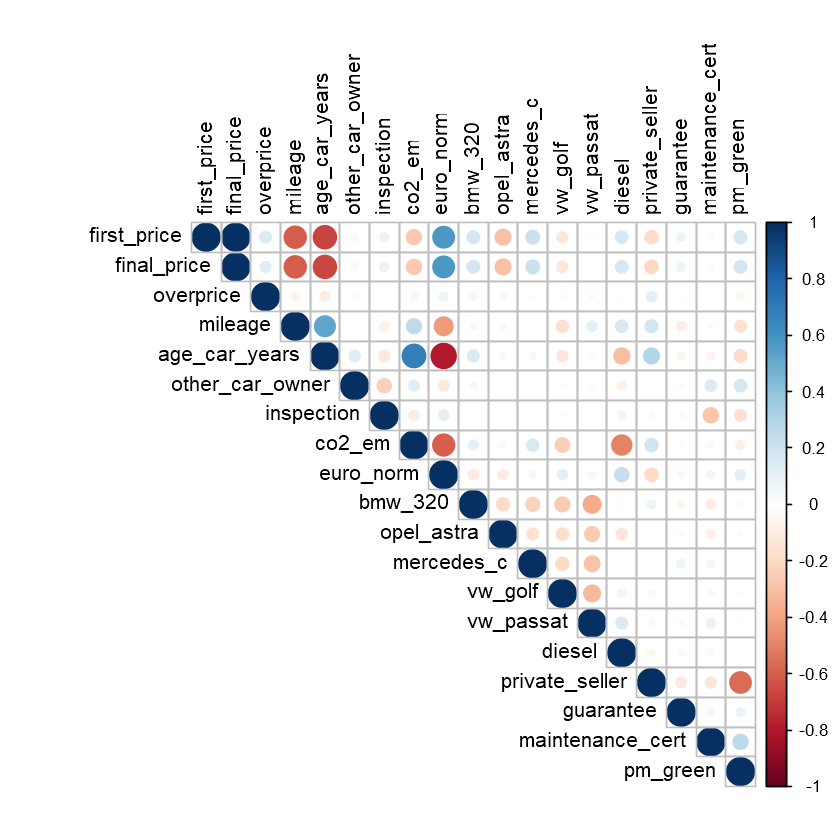

In [22]:
########################  Correlation Matrix  ########################

corr = cor(df)
corrplot(corr, type = "upper", tl.col = "black")

## Extract Data

We extract the variables from the data frame and drop observations with missing values.

In [23]:
########################  Extract Dataset  ########################

# Extracting continuous variables
baseline_covariates_cont <- df %>%
  dplyr::select(baseline_covariates_cont) 

# Extracting indicator variables
baseline_covariates_bin <- df %>%
  dplyr::select(baseline_covariates_bin)

# Extracting outcome 
outcomes <- df %>% dplyr::select(outcomes)

# Setting up the data, renaming columns and discarding rows with NA (if any)
df <- bind_cols(outcomes, baseline_covariates_cont, baseline_covariates_bin) %>%
  na.omit()

print('Data successfully extracted.')

[1] "Data successfully extracted."


## Take Hold-Out-Sample and Scale Data

We want to compare the relative prediction power of different estimation procedures based on the out-of-sample MSE and $R^2$. For this purpose, we create an hold-out-sample. 

Furthermore, we standardise the continuous covariates by the means and standard deviations. Some machine learning algorithms are sensitive to rescaling. Even though most machine learning procedures standardise the covariates automatically, this is a cautionary transformation for those procedures that have no automatic standardisation implemented.

In [24]:
########################  Take Hold-Out-Sample  ########################

df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs) # Training and estimation sample
df_hold_out <- as.data.frame(df_part$hold_out) # Hold-out-sample

# Outcomes
first_price_obs <- as.matrix(df_obs[,1])
final_price_obs <- as.matrix(df_obs[,2])
overprice_obs <- as.matrix(df_obs[,3])

first_price_hold_out <- as.matrix(df_hold_out[,1])
final_price_hold_out <- as.matrix(df_hold_out[,2])
overprice_hold_out <- as.matrix(df_hold_out[,3])

## Covariates/Features
baseline_covariates_cont_obs <- as.matrix(df_obs[,c(4:9)])
baseline_covariates_bin_obs <- as.matrix(df_obs[,c(10:19)])
baseline_covariates_hold_cont_out <- as.matrix(df_hold_out[,c(4:9)])
baseline_covariates_hold_bin_out <- as.matrix(df_hold_out[,c(10:19)])

# Standardise continuous covariates
preProcValues <- preProcess(baseline_covariates_cont_obs, method = c("center", "scale")) # Take means and standard deviations from training sample
ObsTransformed <- predict(preProcValues, baseline_covariates_cont_obs) # Apply the transformation to trainings sample
HoldOutTransformed <- predict(preProcValues, baseline_covariates_hold_cont_out) # Apply the transformation to hold-out-sample (based on means and standard deviations from training sample)
# Note: Outcome variables are not rescaled

baseline_covariates_obs <- as.matrix(cbind(ObsTransformed,baseline_covariates_bin_obs)) 
baseline_covariates_hold_out <- as.matrix(cbind(HoldOutTransformed,baseline_covariates_hold_bin_out)) 
                  
print('The data is now ready for your first analysis!')

[1] "The data is now ready for your first analysis!"


# Tree Estimators

We start the prediction of the final used car price with a tree estimator. Trees partition the sample into mutually exclusive groups $l_j$, which are called terminal leaves. Let $\pi= \{ l_1, ...,l_{\# (\pi)} \}$ be a specific tree or sample partition, let $l_j \equiv l_j (x,\pi)$ be the respective terminal leaf (for $j=1,…,\#(\pi))$, and let $\#(\pi)$ be the number of terminal leaves in tree $\pi$. The terminal leaf $l_j (x,\pi)$ of tree $\pi$ is a function of the covariates $X_{i}$ (for $i = 1,..., N$ used cars) such that $x \in l_j$. 

For an explicit example, consider that $X_{i}$ contains only a binary indicator for used diesel cars. Then, we can choose between two possible trees; either we make no sample split, $\pi'=\{ l_1 \}=\{ \mbox{diesel}, \mbox{gasoline} \}$, or we partition used diesel and gasoline cars into two separate leaves, $\pi'' =\{ l_1,l_2 \}= \{ \{ \mbox{diesel} \}, \{ \mbox{gasoline} \} \}$.  

Trees select the partition $\pi$ by recursively adding leaves to the tree that minimise the MSE. Accordingly, trees aim to partition the sample into leaves with homogeneous outcomes. Because of the hierarchical partition structure, the first splits contribute more prediction power than the last splits. 


For a specific tree $\pi$, you can predict the final used car price by
\begin{equation*}
\hat{E}[final\_price|X_i=x,\pi] = \frac{1}{\sum_{i=1}^{N}1\{ X_{i} \in l_j(x,\pi)\}}\sum_{i=1}^{N} 1\{ X_{i} \in l_j(x,\pi)\} \cdot final\_price.
\end{equation*}



## Shallow Tree

We start the analysis with a reletively small (shallow) tree, by imposing the restriction that each terminal leave needs to contain at least 500 used cars.

[1] "Relative CV-MSE for different tree sizes"
           CP nsplit rel error    xerror       xstd
1 0.323555506      0 1.0000000 1.0001682 0.02314271
2 0.108559478      1 0.6764445 0.6768081 0.01762231
3 0.048975900      2 0.5678850 0.5716811 0.01811835
4 0.028696527      3 0.5189091 0.5244401 0.01712483
5 0.024445429      4 0.4902126 0.4958408 0.01698741
6 0.010814262      5 0.4657672 0.4774923 0.01685817
7 0.009932285      6 0.4549529 0.4611415 0.01646857
8 0.000020000      7 0.4450206 0.4568488 0.01644073


png 
  2

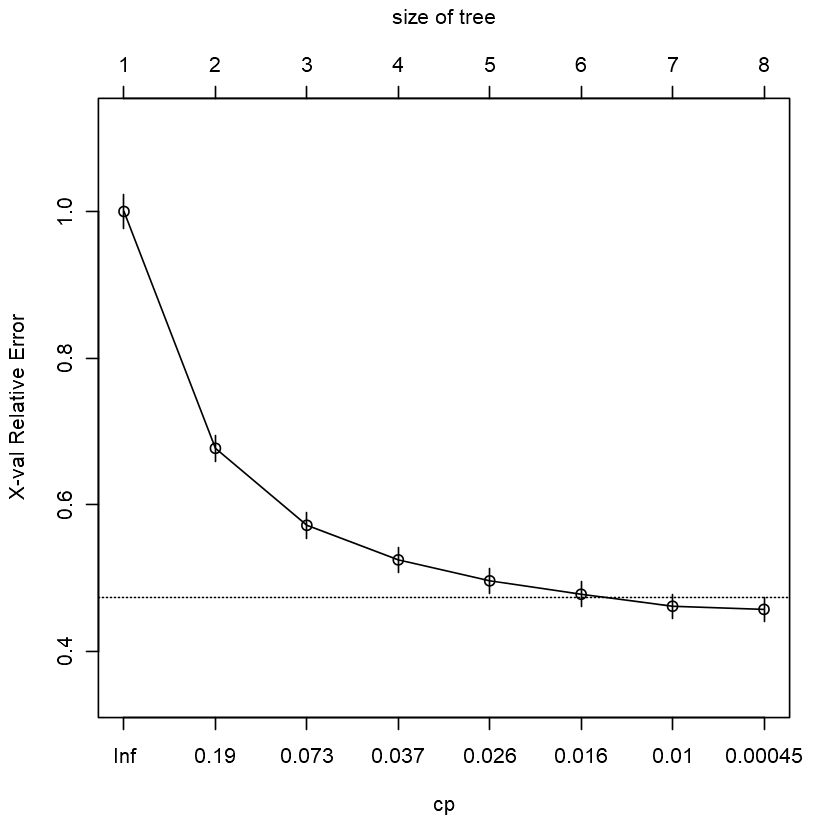

In [25]:
########################  Build Trees with different Leave Sizes  ########################                         

# Prepare data for tree estimator
tree_data_obs <-  data.frame(final_price_obs, baseline_covariates_obs)

# Setup the formula of the linear regression model
sumx <- paste(baseline_covariates, collapse = " + ")  
linear <- paste("final_price_obs",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build the tree
linear.singletree_1 <- rpart(formula = linear, data = tree_data_obs , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=500))
# Note: 'minbucket=500' imposes the restriction that each terminal leave should contain at least 500 used cars. Algorithm 'rpart' stops growing trees when either one leave has less than 500 observations or the MSE gain of addidng one addidtional leave is below cp=0.00002.

print('Relative CV-MSE for different tree sizes')
print(linear.singletree_1$cptable)

# Plot CV-MSE
plotcp(linear.singletree_1)

# Save CV-MSE as png-file
png(filename= "cp_tree1.png", units="in", width=5, height=4, pointsize=12, res=72)
    plotcp(linear.singletree_1)
dev.off()

We select the tree that minimises the CV-MSE.

In [26]:
########################  Select the Tree that Minimises CV-MSE  ######################## 

op.index_1 <- which.min(linear.singletree_1$cptable[, "xerror"])
print(paste0("Optimal number final leaves: ", op.index_1))

# Get cp-value that corresponds to optimal tree size
cp.vals_1 <- linear.singletree_1$cptable[op.index_1, "CP"]

[1] "Optimal number final leaves: 8"


The CV-MSE is minimised at the maximum leave size of eight. This suggests that the tree is not deep enough to unfold the bias-variance trade-off. For illustrational purposes, we continue working with this shallow tree, but later we will relax the restrictions on the minimum leave size.

Next we estimate RMSE and $R^2$ to evaluate the performance of the shallow tree.

In [27]:
########################  Select the Optimal Tree and Assess Out-of-Sample Performance  ######################## 

# Prune the tree
treepruned.linearsingle_1 <- prune(linear.singletree_1, cp = cp.vals_1)

extr_covariates_obs <- as.data.frame(baseline_covariates_obs)
extr_covariates_hold_out <- as.data.frame(baseline_covariates_hold_out)

# Predict final price in the observed and hold-out-samples
pred_tree_hold_out_1 <- as.matrix(predict(treepruned.linearsingle_1, newdata=extr_covariates_hold_out))
pred_tree_obs_1 <- as.matrix(predict(treepruned.linearsingle_1, newdata=extr_covariates_obs))

## Assess performance of tree estimator
# In-sample RMSE
rmse_obs_1 <- round(sqrt(mean((final_price_obs - pred_tree_obs_1)^2)),digits=3)
# Hold-out-sample RMSE
rmse_hold_out_1 <- round(sqrt(mean((final_price_hold_out - pred_tree_hold_out_1)^2)),digits=3)
# In-sample R-squared
r2_obs_1 <- round(1-mean((final_price_obs - pred_tree_obs_1)^2)/mean((final_price_obs - mean(final_price_obs))^2),digits=3)
# Hold-out-sample R-squared
r2_hold_out_1 <- round(1-mean((final_price_hold_out - pred_tree_hold_out_1)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("In-Sample RMSE: ", rmse_obs_1))
print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_1))
print(paste0("In-Sample R-squared: ", r2_obs_1))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_1))

[1] "In-Sample RMSE: 4.794"
[1] "Hold-out-Sample RMSE: 4.859"
[1] "In-Sample R-squared: 0.555"
[1] "Hold-out-Sample R-squared: 0.529"


By splitting the sample into eight groups, we can explain already 53\% of the out-of-sample *final_price*. Next, we visualise the tree by plotting the tree structure.

png 
  2

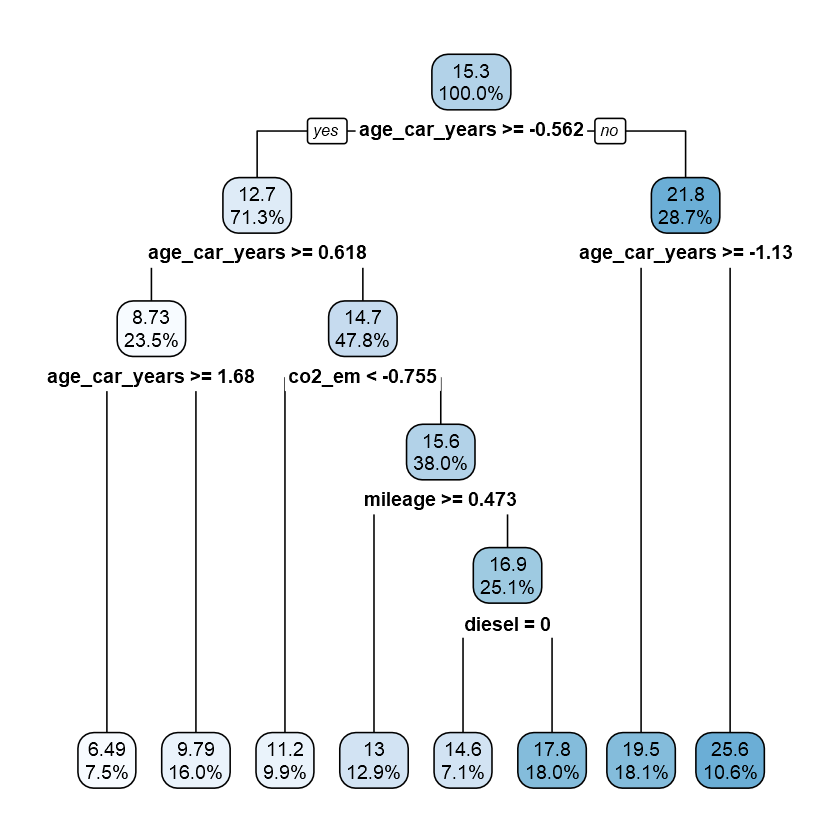

In [28]:
########################  Visulatisation of tree  ######################## 

## Plot tree structure
rpart.plot(treepruned.linearsingle_1,digits=3)
# Note: All continuous variables are standardised.

# Save tree structure as png-file
png(filename= "full_tree1.png",units="in", width=9, height=9, pointsize=12,res=72)
    rpart.plot(treepruned.linearsingle_1,digits=3)
dev.off()

We have to be careful when interpreting the leaves of the tree. That some sample splits are based on, e.g., *car_age_years* does not necessarily mean that *car_age_years* causally affects *final_price*. The reason is, *car_age_years* is correlated with several other covartiates (e.g., *mileage* and *co2_em*). Possibly, the causal effect operates through one of the correlated covariates and *car_age_years* is just a good proxy for them. To demonstrate this, we plot the average value of each covariate for each leaf.


png 
  2

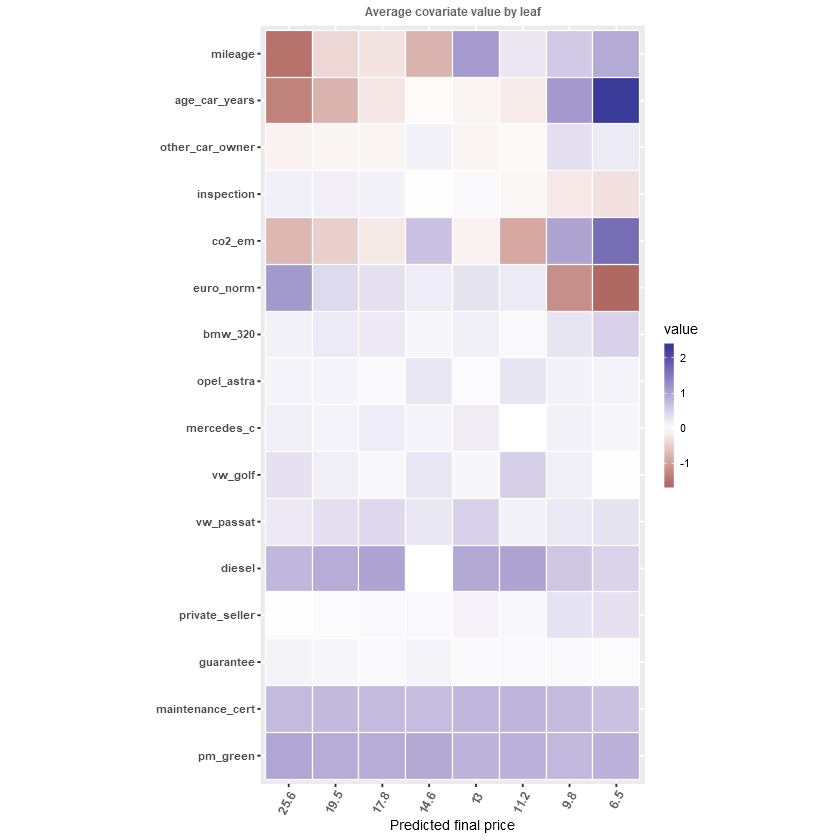

In [29]:
######################## Average Value of Each Covariate by Leaf  ######################## 
## Code from Susan Athey and Guido Imbens AEA lecture

# Take hold-out data only
tree_data_out <- data.frame(pred_tree_hold_out_1, baseline_covariates_hold_out)

# Map to each individual row the leaf number and add the covariates
individual_leaf <- treeClust::rpart.predict.leaves(treepruned.linearsingle_1, tree_data_out)  %>% 
  as_tibble()  %>% 
  dplyr::rename(leaf=value) 
leaf_covariates <- cbind(individual_leaf, tree_data_out[baseline_covariates])

# Get predicted final price of each leaf 
leaf_price <- treepruned.linearsingle_1$frame %>% as_tibble() %>%
  dplyr::mutate(row = 1:nrow(.)) %>% 
  dplyr::filter(var == "<leaf>") %>% 
  dplyr::rename(leaf=row, pred_price=yval) %>% 
  dplyr::select(leaf, pred_price) 

# Merge all the information on leaf level
leaf_data <- left_join(leaf_covariates, leaf_price, by="leaf")

# Mean of each covariate on each leaf, 
# Leafs sorted and renumbered by predicted prive
leaf_mean <- leaf_data %>% 
  dplyr::group_by(leaf) %>%
  dplyr::summarise_all(mean) %>%
  dplyr::arrange(desc(pred_price)) %>%
  dplyr::mutate(leaf = 1:nrow(.)) 

# Plot
plt <- leaf_mean %>% 
  dplyr::select(leaf, baseline_covariates[c(16:1)]) %>%
  melt(id="leaf") %>%
  ggplot(aes(x=factor(leaf), y=variable, fill=value)) +
  geom_raster() +
  scale_fill_gradient2() + 
  scale_x_discrete(breaks=seq_along(leaf_mean$pred_price),      
                   labels=round(leaf_mean$pred_price, 1)) +
  # From here on, all the code is optional styling
  geom_tile(colour="white",size=0.25) +            # white cell border
  labs(x="Predicted final price",
       y="", title="Average covariate value by leaf") +# axis labels 
  coord_fixed()+                                   # square cells
  theme_grey(base_size=8)+                         # basic hue 
  theme(
    axis.text=element_text(face="bold"),      # axis font style
    plot.background=element_blank(),          # cleaner background
    panel.border=element_blank(),             # cleaner panel
    legend.key.width=grid::unit(0.2,"cm"),    # slim legend color bar
    axis.ticks=element_line(size=0.4),        # tick style
    axis.text.x=element_text(size=7,          # tick label style
                             colour="grey40",
                             angle = 60,
                             hjust = 1),
    plot.title=element_text(colour="grey40",  # plot title style
                            hjust=.5,size=7,
                            face="bold")
  )

plot(plt)

# Save average covariate values as png-file
png(filename= "regressor_values.png",units="in", width=6, height=6, pointsize=38,res=300)
    plt
dev.off()

The structure of the average covariates is similar for *milage*, *age_car_years* and negatively correlated with *euro_norm*. Accordingly, all of these variables could to some extend replace each other for the prediction of *final_price*. 

## Deep Tree

Now we relax the restriction on the minimum leave size.

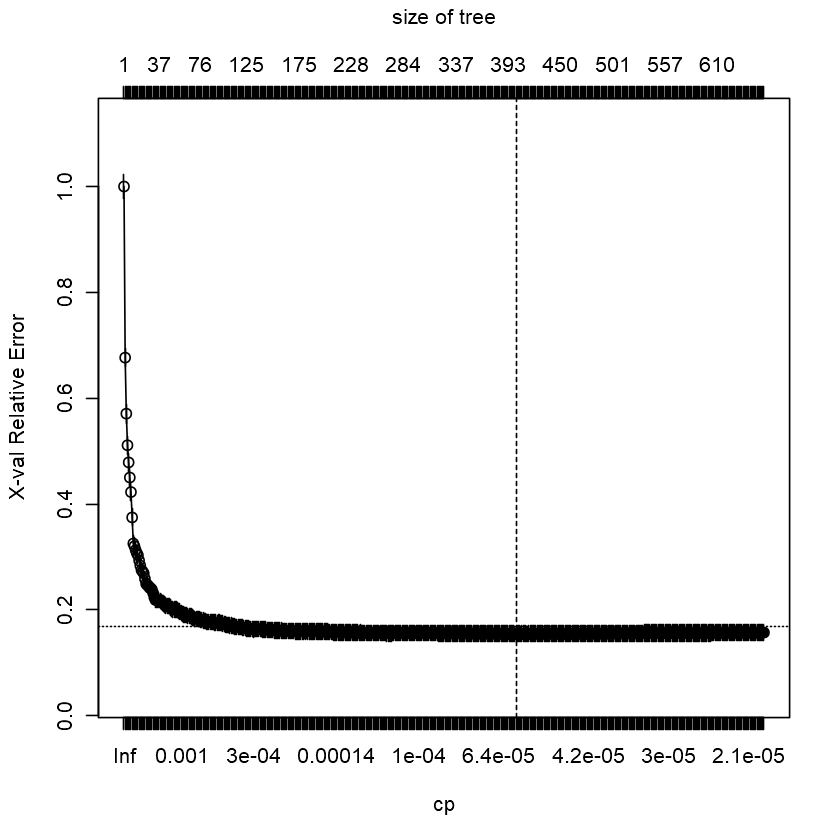

In [30]:
######################## Deep tree estimator  ########################                         

# Build deep Tree
linear.singletree_2 <- rpart(formula = linear, data = tree_data_obs , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=5))

# Find tree size that minimises CV-MSE
op.index_2 <- which.min(linear.singletree_2$cptable[, "xerror"])

# Plot CV-MSE
plotcp(linear.singletree_2)
abline(v = op.index_2, lty = "dashed")

We plot the struture of the deep tree.

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

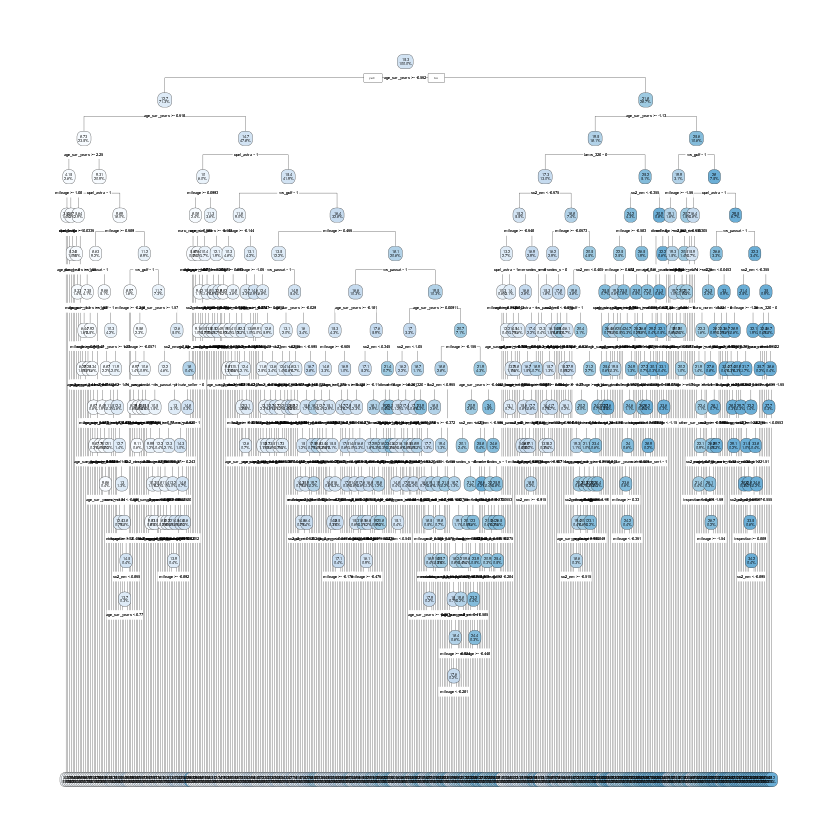

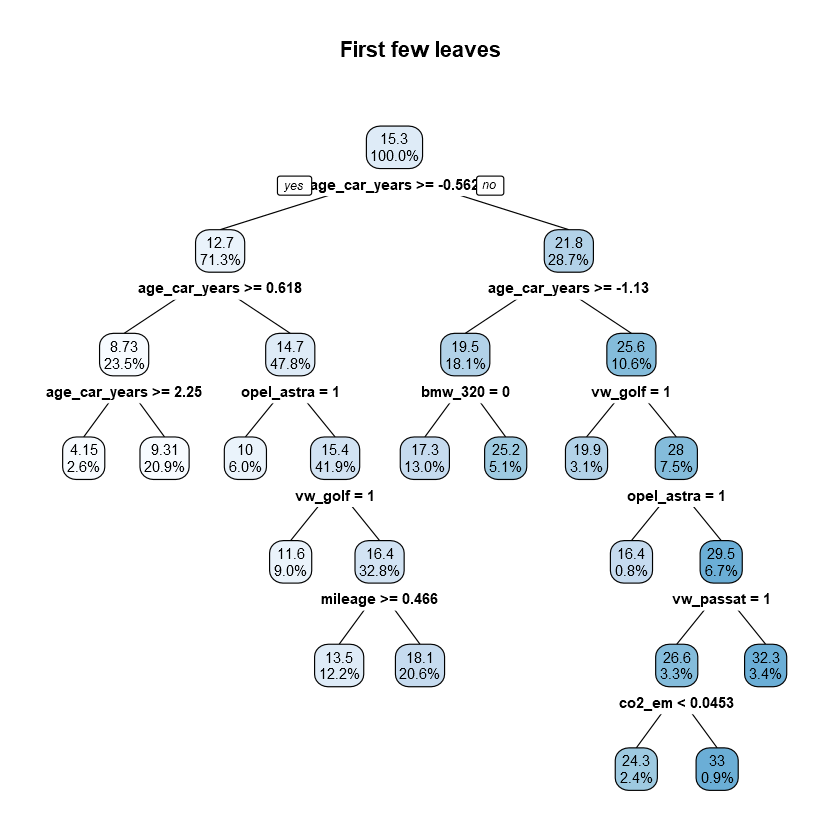

In [31]:
# Get cp-value that corresponds to optimal tree size
cp.vals_2 <- linear.singletree_2$cptable[op.index_2, "CP"]

# Prune the tree
treepruned.linearsingle_2 <- prune(linear.singletree_2, cp = cp.vals_2)

# Plot tree structure
rpart.plot(treepruned.linearsingle_2,digits=3)
treepruned.linearsingle_2_short <- prune(linear.singletree_2, cp = 150*cp.vals_2)
rpart.plot(treepruned.linearsingle_2_short,digits=3, main = "First few leaves",fallen.leaves=FALSE)


It is too complex to plot and understand the entire tree. However, we can look at the first few splits of the deep tree: Because of the hirachical tree structure the first splits make the largest contribution to the prediction of *final_price*. 

In [32]:
# Predict final price in the observed and hold-out-samples
pred_tree_hold_out_2 <- as.matrix(predict(treepruned.linearsingle_2, newdata=extr_covariates_hold_out))
pred_tree_obs_2 <- as.matrix(predict(treepruned.linearsingle_2, newdata=extr_covariates_obs))

## Assess performance of tree estimator
# In-sample RMSE
rmse_obs_2 <- round(sqrt(mean((final_price_obs - pred_tree_obs_2)^2)),digits=3)
# Hold-out-sample RMSE
rmse_hold_out_2 <- round(sqrt(mean((final_price_hold_out - pred_tree_hold_out_2)^2)),digits=3)
# In-sample R-squared
r2_obs_2 <- round(1-mean((final_price_obs - pred_tree_obs_2)^2)/mean((final_price_obs - mean(final_price_obs))^2),digits=3)
# Hold-out-sample R-squared
r2_hold_out_2 <- round(1-mean((final_price_hold_out - pred_tree_hold_out_2)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("In-Sample RMSE: ", rmse_obs_2))
print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_2))
print(paste0("In-Sample R-squared: ", r2_obs_2))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_2))

[1] "In-Sample RMSE: 2.132"
[1] "Hold-out-Sample RMSE: 2.928"
[1] "In-Sample R-squared: 0.912"
[1] "Hold-out-Sample R-squared: 0.829"


We can compare the relative performance of the shallow and deep tree. The deep tree has substaintially better prediction power than the shallow tree. However, the deep tree is more difficult to interpret than the shallow tree.

## Deep Honest Tree

It is difficult to obtain valid inference after model selection when the same data is used to train and estimate the tree. The honest tree partitions the sample randomly into training and estimation sample. The training sample is used to build the tree and to select the optomal tree size based on the CV procedure. Afterwards the pruned tree is used to estimnate the *final_price* in the estimation sample. Based on an independent sampling argument we can ignore the model selection step to compute the inference of the honest tree.

[1] "Training-Sample RMSE: 2.539"
[1] "Estimation-Sample RMSE: 2.724"
[1] "Hold-out-Sample RMSE: 2.971"
[1] "Training-Sample R-squared: 0.876"
[1] "Estimation-Sample R-squared: 0.855"
[1] "Hold-out-Sample R-squared: 0.824"


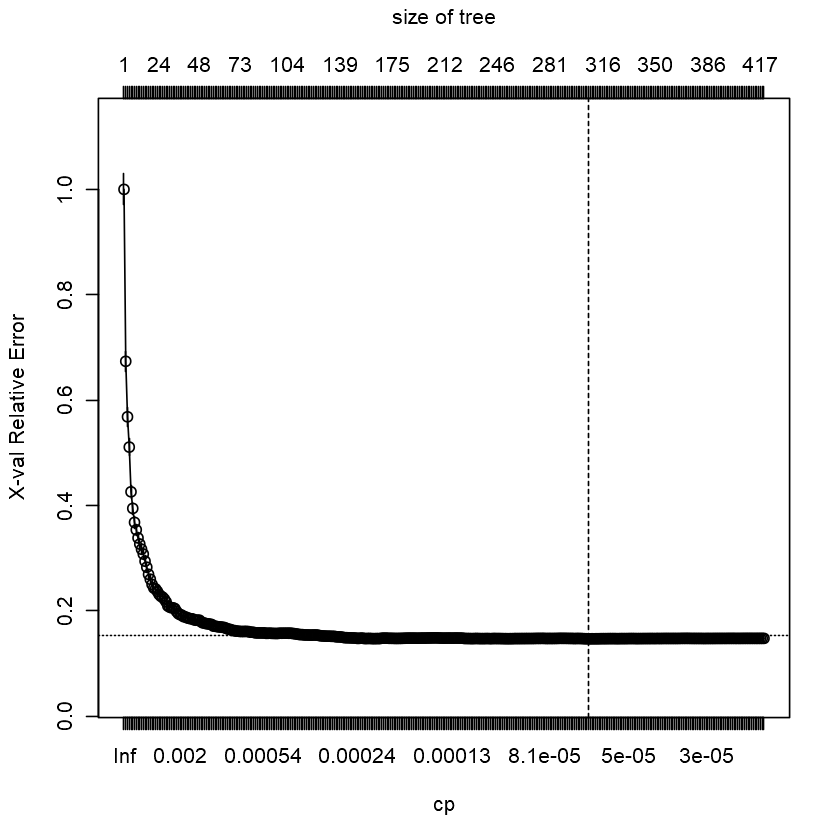

In [33]:
######################## Honest deep tree estimator ########################                        

# Create tratining and estimation sample
df_obs_part <- modelr::resample_partition(df_obs, c(train = 0.5, est = 0.5))
df_train <- as.data.frame(df_obs_part$train)
df_est <- as.data.frame(df_obs_part$est)

# Outcomes
final_price_train <- as.matrix(df_train[,2])
final_price_est <- as.matrix(df_est[,2])

# Covariates/Features
baseline_covariates_hold_cont_out <- as.matrix(df_hold_out[,c(4:9)])
baseline_covariates_cont_train <- as.matrix(df_train[,c(4:9)]) 
baseline_covariates_cont_est <- as.matrix(df_est[,c(4:9)])
baseline_covariates_hold_bin_out <- as.matrix(df_hold_out[,c(10:19)])
baseline_covariates_bin_train <- as.matrix(df_train[,c(10:19)]) 
baseline_covariates_bin_est <- as.matrix(df_est[,c(10:19)])

baseline_covariates_hold_out <- as.matrix(cbind(baseline_covariates_hold_cont_out,baseline_covariates_hold_bin_out)) 
baseline_covariates_train <- as.matrix(cbind(baseline_covariates_cont_train,baseline_covariates_bin_train)) 
baseline_covariates_est <- as.matrix(cbind(baseline_covariates_cont_est,baseline_covariates_bin_est)) 

# Prepare data for tree estimator
tree_data_train <-  data.frame(final_price_train, baseline_covariates_train)
tree_data_est <-  data.frame(final_price_est, baseline_covariates_est)
tree_data_hold_out <-  data.frame( baseline_covariates_hold_out)

# Setup the formula of the linear regression model
linear <- paste("final_price_train",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build deep tree
linear.singletree_3 <- rpart(formula = linear, data = tree_data_train , method = "anova", xval = 10,
                             control = rpart.control(cp = 0.00002, minbucket=5), model = TRUE)

# Find tree size that minimises CV-MSE
op.index_3 <- which.min(linear.singletree_3$cptable[, "xerror"])

# Plot CV-MSE
plotcp(linear.singletree_3)
abline(v = op.index_3, lty = "dashed")

# Get cp-value that corresponds to optimal tree size
cp.vals_3 <- linear.singletree_3$cptable[op.index_3, "CP"]

# Prune the tree
treepruned.linearsingle_3 <- prune(linear.singletree_3, cp = cp.vals_3)

# Extrapolate Tree to Estimation Sample
extr_covariates_train <-  as.data.frame(baseline_covariates_train)
extr_covariates_est <-  as.data.frame(baseline_covariates_est)
extr_covariates_hold_out <-  as.data.frame(baseline_covariates_hold_out)

leaves <- as.factor(rpart.predict.leaves(treepruned.linearsingle_3, newdata= extr_covariates_train, type = "where"))
dummies_train = model.matrix(~leaves )

leaves <- as.factor(rpart.predict.leaves(treepruned.linearsingle_3, newdata= extr_covariates_est, type = "where"))
dummies_est = model.matrix(~leaves )

leaves <- as.factor(rpart.predict.leaves(treepruned.linearsingle_3, newdata= extr_covariates_hold_out, type = "where"))
dummies_out = model.matrix(~leaves )

nam_train <- as.vector(colnames(dummies_train))
nam_est <- as.vector(colnames(dummies_est))
nam_out <- as.vector(colnames(dummies_out))

for (i in c(1:ncol(dummies_train))) {
    if (nam_train[i] != nam_est[i]) {
        s = i -1
        dummies_est <- as.matrix(cbind(dummies_est[,c(1:s)],rep(0,times=nrow(dummies_est)), 
                                       dummies_est[,c(i:ncol(dummies_est))]))
        nam_est <- as.vector(c(nam_est[c(1:s)],"NA", nam_est[c(i:length(nam_est))]))
    }
    
}

for (i in c(1:ncol(dummies_train))) {
    if (nam_train[i] != nam_out[i]) {
        s = i -1
        dummies_out <- as.matrix(cbind(dummies_out[,c(1:s)],rep(0,times=nrow(dummies_out)), 
                                       dummies_out[,c(i:ncol(dummies_out))]))
        nam_out <- as.vector(c(nam_out[c(1:s)],"NA", nam_out[c(i:length(nam_out))]))
    }
    
}


res <- lm.fit(dummies_est,final_price_est)
coef <- as.matrix(res$coefficients)
coef[is.na(coef)] <- 0

# Prediction
pred_tree_est_3 <- as.matrix(res$fit)
pred_tree_hold_out_3  <- as.matrix(dummies_out) %*% as.matrix(coef)
pred_tree_train_3 <- as.matrix(dummies_train) %*% as.matrix(coef)

## Assess performance of tree estimator
# Training-sample RMSE
rmse_train_3 <- round(sqrt(mean((final_price_train - pred_tree_train_3)^2)),digits=3)
# Estimation-sample RMSE
rmse_est_3 <- round(sqrt(mean((final_price_est - pred_tree_est_3)^2)),digits=3)
# Hold-out-sample RMSE
rmse_hold_out_3 <- round(sqrt(mean((final_price_hold_out - pred_tree_hold_out_3)^2)),digits=3)
# Training-sample R-squared
r2_train_3 <- round(1-mean((final_price_train - pred_tree_train_3)^2)/mean((final_price_train - mean(final_price_train))^2),digits=3)
# Estimation-sample R-squared
r2_est_3 <- round(1-mean((final_price_est - pred_tree_est_3)^2)/mean((final_price_est - mean(final_price_est))^2),digits=3)
# Hold-out-sample R-squared
r2_hold_out_3 <- round(1-mean((final_price_hold_out - pred_tree_hold_out_3)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("Training-Sample RMSE: ", rmse_train_3))
print(paste0("Estimation-Sample RMSE: ", rmse_est_3))
print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_3))
print(paste0("Training-Sample R-squared: ", r2_train_3))
print(paste0("Estimation-Sample R-squared: ", r2_est_3))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_3))


We do not necessarily loose much prediction power using the honest tree, but we have a better chance to obtain valid inference.

## Deep Honest Cross-Fitted Tree

We can pimp the prediction power of our honest tree with a cross-fitting procedure. This means that we built two honest trees by switching the training and estimation sample. The cross-fitted honest tree is the average of the two hoinest trees.

[1] "Hold-out-Sample RMSE: 2.77"
[1] "Hold-out-Sample R-squared: 0.847"


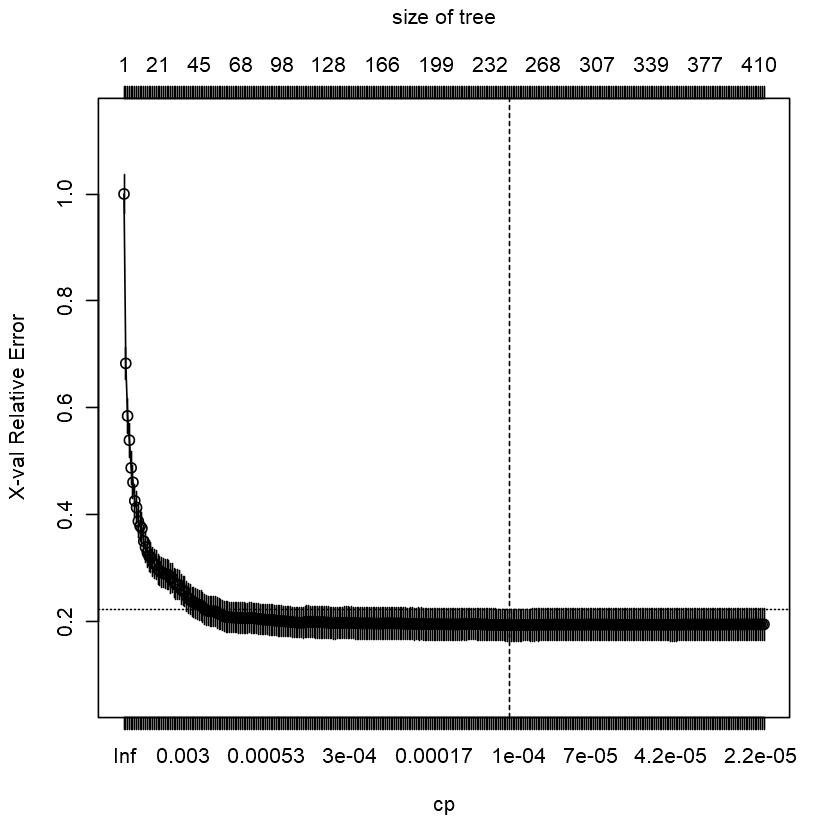

In [34]:
########################  Crossfitted honest deep tree estimator  ########################                        

# Setup the formula of the linear regression model for the first tree
linear <- paste("final_price_est",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build first deep tree
linear.singletree_4 <- rpart(formula = linear, data = tree_data_est , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=5))

# Find tree size that minimises CV-MSE
op.index_4 <- which.min(linear.singletree_4$cptable[, "xerror"])

# Plot CV-MSE
plotcp(linear.singletree_4)
abline(v = op.index_4, lty = "dashed")

# Get cp-value that corresponds to optimal tree size
cp.vals_4 <- linear.singletree_4$cptable[op.index_4, "CP"]

# Prune the tree
treepruned.linearsingle_4 <- prune(linear.singletree_4, cp = cp.vals_4)

# Extrapolate Tree to Estimation Sample
leaves <- as.factor(rpart.predict.leaves(treepruned.linearsingle_4, newdata= extr_covariates_est, type = "where"))
dummies_train = model.matrix(~leaves )

leaves <- as.factor(rpart.predict.leaves(treepruned.linearsingle_4, newdata= extr_covariates_train, type = "where"))
dummies_est = model.matrix(~leaves )

leaves <- as.factor(rpart.predict.leaves(treepruned.linearsingle_4, newdata= extr_covariates_hold_out, type = "where"))
dummies_out = model.matrix(~leaves )

nam_train <- as.vector(colnames(dummies_train))
nam_est <- as.vector(colnames(dummies_est))
nam_out <- as.vector(colnames(dummies_out))

for (i in c(1:ncol(dummies_train))) {
    if (nam_train[i] != nam_est[i]) {
        s = i -1
        dummies_est <- as.matrix(cbind(dummies_est[,c(1:s)],rep(0,times=nrow(dummies_est)), 
                                       dummies_est[,c(i:ncol(dummies_est))]))
        nam_est <- as.vector(c(nam_est[c(1:s)],"NA", nam_est[c(i:length(nam_est))]))
    }
    
}

for (i in c(1:ncol(dummies_train))) {
    if (nam_train[i] != nam_out[i]) {
        s = i -1
        dummies_out <- as.matrix(cbind(dummies_out[,c(1:s)],rep(0,times=nrow(dummies_out)), 
                                       dummies_out[,c(i:ncol(dummies_out))]))
        nam_out <- as.vector(c(nam_out[c(1:s)],"NA", nam_out[c(i:length(nam_out))]))
    }
    
}

res <- lm.fit(dummies_est,final_price_train)
coef <- as.matrix(res$coefficients)
coef[is.na(coef)] <- 0

# Prediction

pred_tree_hold_out_4  <- as.matrix(dummies_out) %*% as.matrix(coef)

#####

## Assess performance of tree estimator
# Hold-out-sample RMSE
rmse_hold_out_4 <- round(sqrt(mean((final_price_hold_out - 0.5*(pred_tree_hold_out_3 
                            + pred_tree_hold_out_4))^2)),digits=3)
# Hold-out-sample R-squared
r2_hold_out_4 <- round(1-mean((final_price_hold_out - 0.5*(pred_tree_hold_out_3 
                            + pred_tree_hold_out_4))^2)/mean((final_price_hold_out 
                            - mean(final_price_hold_out))^2),digits=3)

print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_4))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_4))